$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# MARBLE IT DOWN!!

### Rohit Tamidapati
#### Key neural network subroutines provided by professor Chuck Anderson, ColoState.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn
import random

In [2]:
import copy

actions = (-1, 0, 1)   # Possible actions

def reinforcement(s, s1):
    return 0 if abs(s1[0]-s[2]) < 1 else -1
    # return -abs(s1[0] - goal)

def initialState(goal = None):
    if goal == None:
        goal = random.randint(1, 10)
        return np.array([10 * np.random.random_sample(), 0.0, goal])
    else:
        return np.array([10 * np.random.random_sample(), 0.0, goal])

def nextState(s, a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0, s[2]]
    elif s[0] > 10:
        s = [10,0, s[2]]
    return s

In [3]:
i = initialState()
i

array([8.71637638, 0.        , 7.        ])

In [4]:
s_next = nextState(i, 0)
s_next

array([8.71637638, 0.        , 7.        ])

In [5]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

In [6]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net, trial, epsilonTrace, rtrace, goal):
    plt.subplot(4, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    plt.subplot(4, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [5, 5], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, goal, a] for a in actions for s in range(15)]))
    plt.subplot(4, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    plt.subplot(4, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    plt.subplot(4, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([4, 6], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(4, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(4, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], goal, a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    plt.subplot(4, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(4, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(4, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

In [8]:
def testIt(Qnet, nTrials, nStepsPerTrial, goal):
    xs = np.linspace(0, 12, nTrials)
    plt.subplot(4, 3, 12)
    for x in xs:
        s = [x, 0, goal] # 0 velocity
        xtrace = np.zeros((nStepsPerTrial, 3))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
            s = nextState(s, a)
            xtrace[step, :] = s
        plt.plot(xtrace[:, 0], xtrace[:, 1])
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.plot([5, 5], [-5, 5], '--', alpha=0.5, lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [9]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

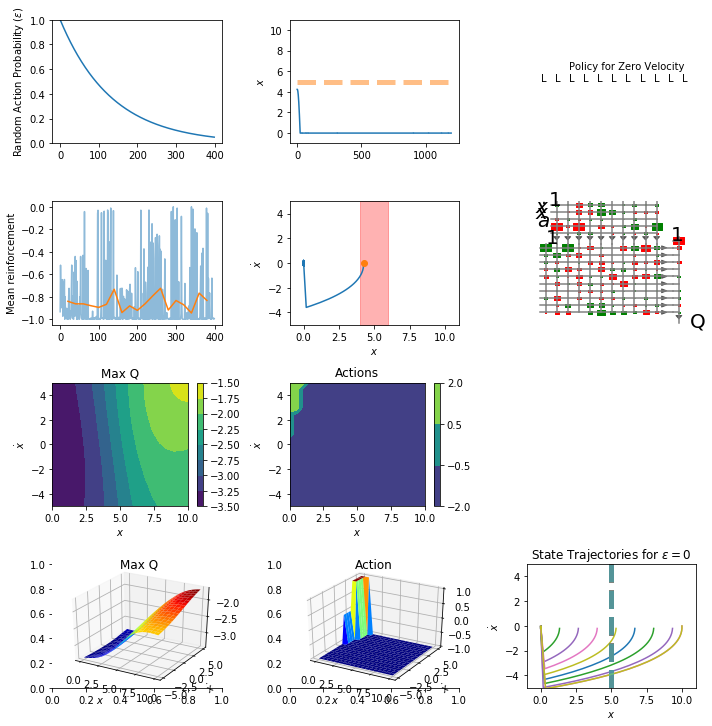

In [10]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.05   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 2, 0], [2, 2, 5, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, X[0,2])
        testIt(nnetQ, 10, 500, X[0, 2])
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 1

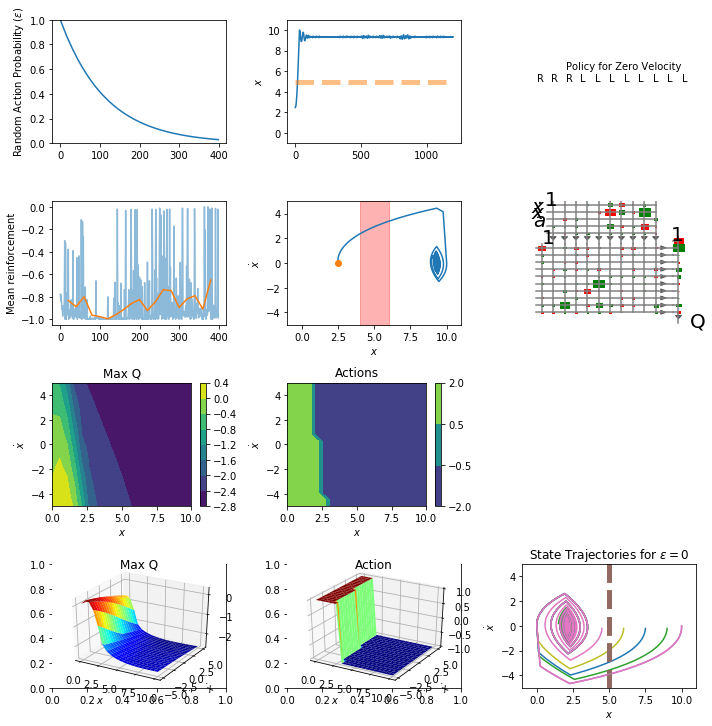

In [10]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 1
gamma = 0.5           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.03   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 9, 400, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 2

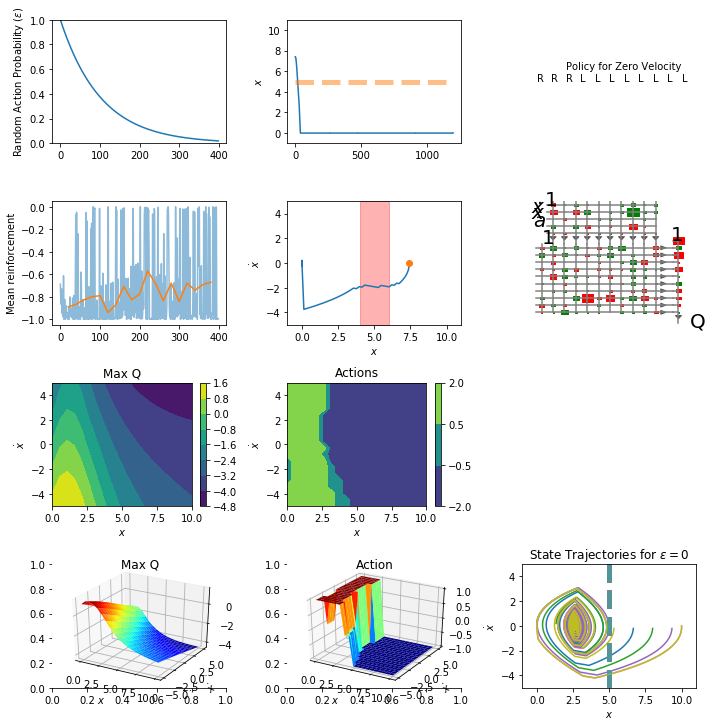

In [12]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 2
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 3

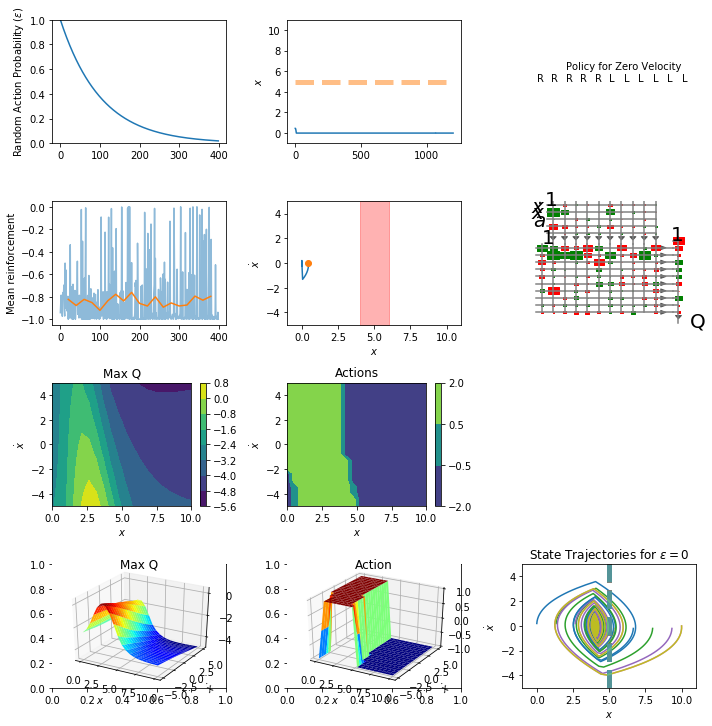

In [13]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 3
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 4

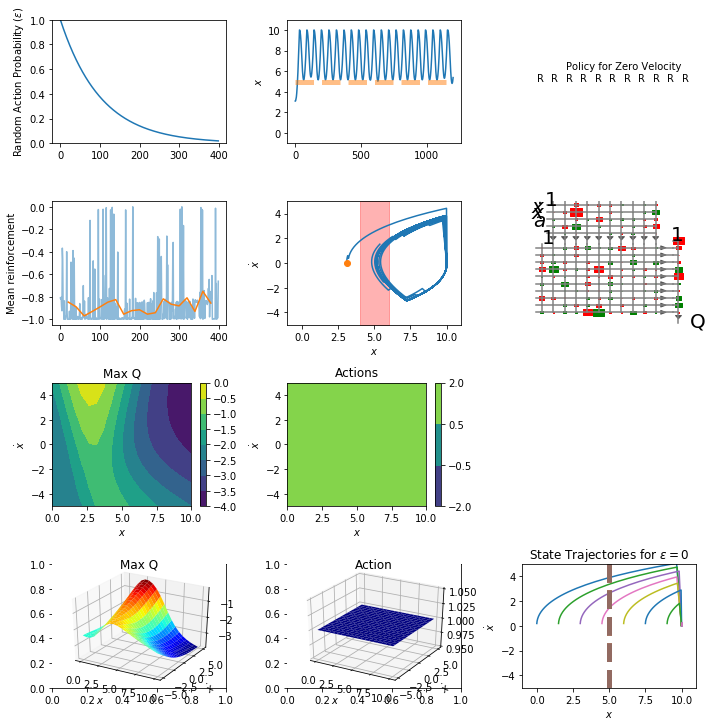

In [14]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 4
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 9, 600, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 5

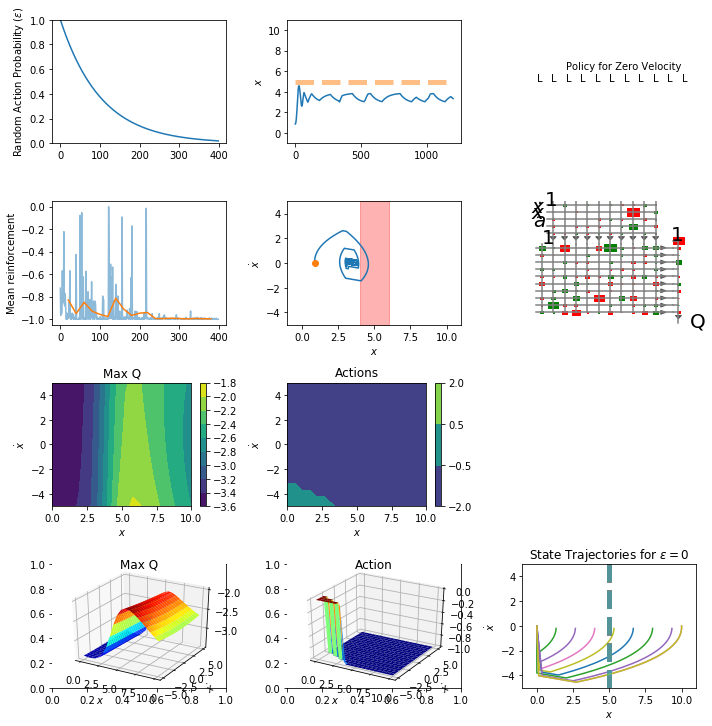

In [15]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 5
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 6

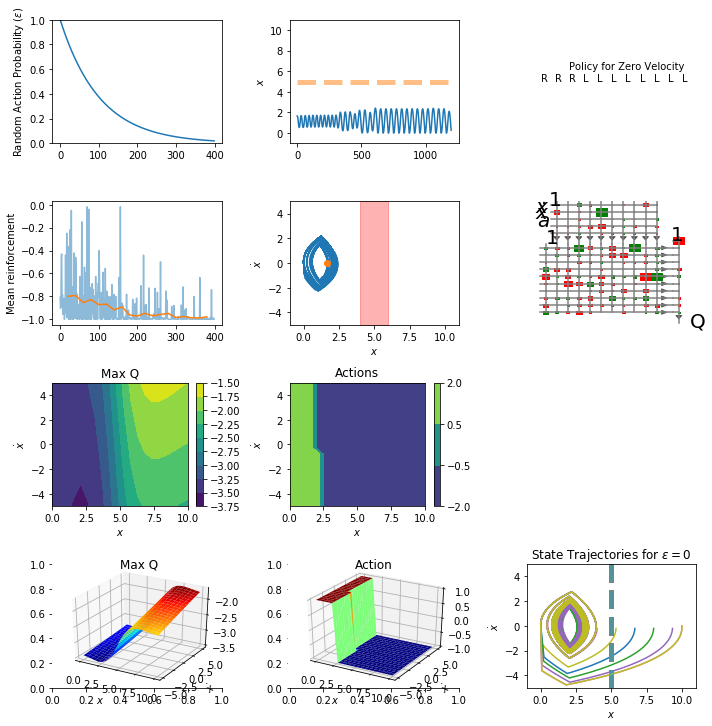

In [16]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 6
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 7

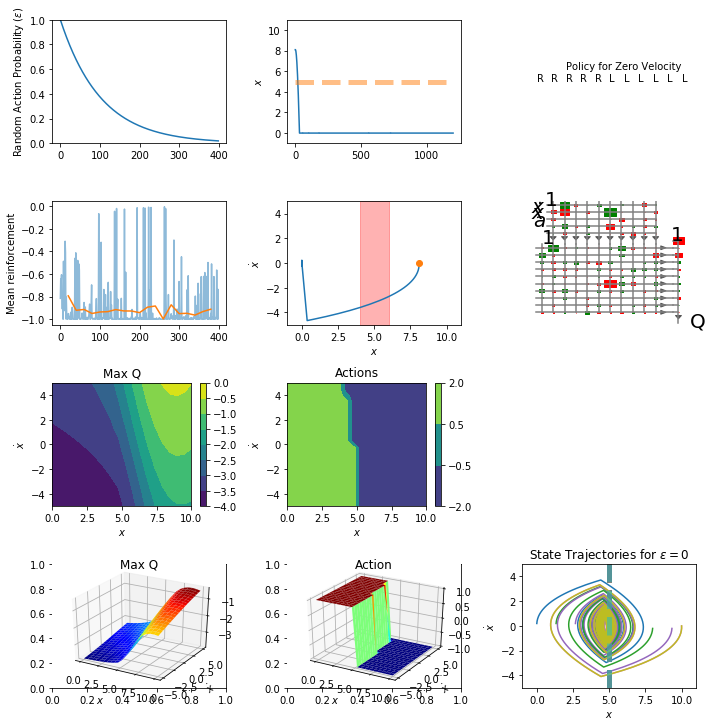

In [17]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 7
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 8

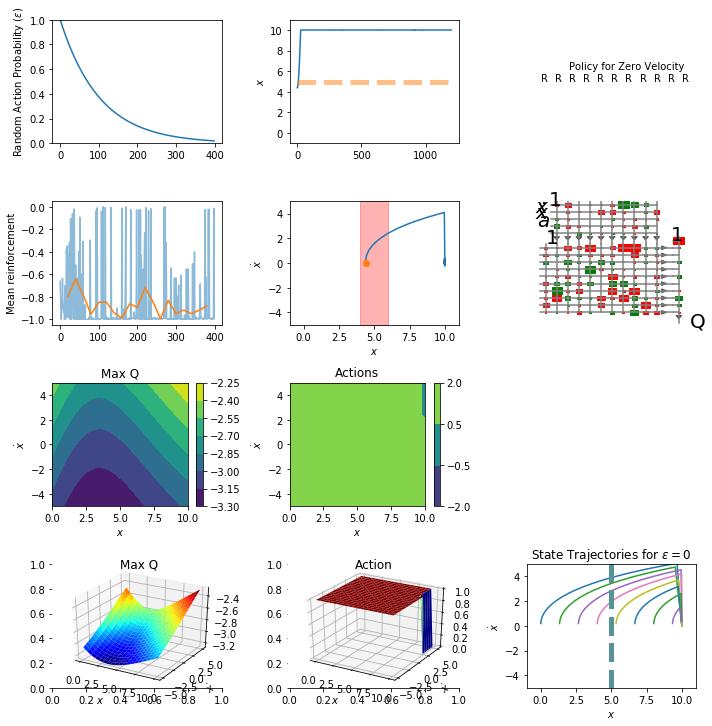

In [18]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 8
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


## Goal at 9

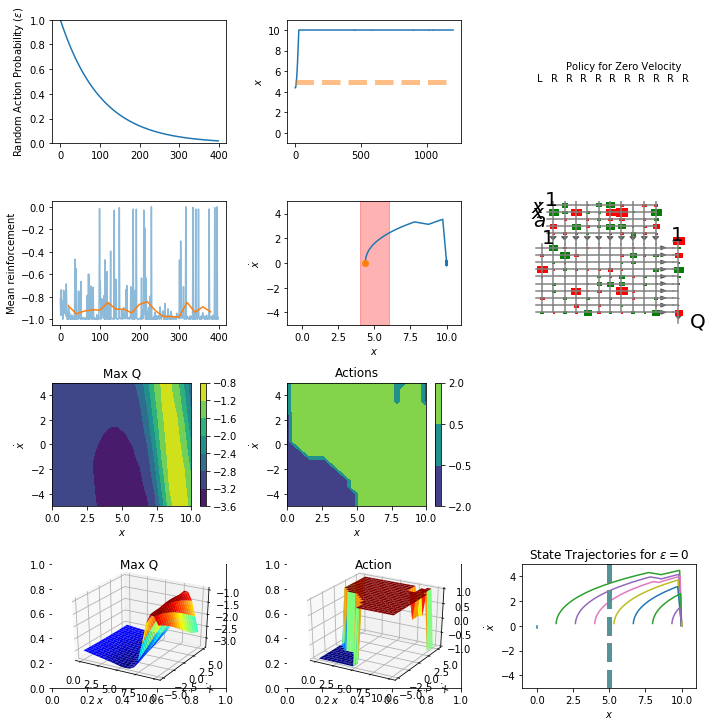

In [19]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

goal = 9
gamma = 0.7           # discount factor
nTrials = 400         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1200 # number of steps between new random initial states
nSCGIterations = 5    # maximum number of SCG iterations
finalEpsilon = 0.02   # value of epsilon at end of simulation. Decay rate is calculated

epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [4, 0, 5, 0], [3, 4, 2, 1], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, goal)
        testIt(nnetQ, 10, 500, goal)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)


In [ ]:
# Action directions of thrust
#   6   1
#    \ /
#  5--0--2
#    / \
#   4   3
validActions = np.array([[0,0],[0.25,np.sqrt(3)/4],[0.5,0],[0.25,-np.sqrt(3)/4],
                         [-0.25,-np.sqrt(3)/4],[-0.5,0],[-0.25,np.sqrt(3)/4]])

def initialState():
    # State is: x&y position, x&y velocity, goal x&y position, goal x&y velocity
    # World has planet at 0,0 and the grid is -10 to 10 in both X and Y
    # The planet starts at X=0, Y=6 with velocity to result in slightly elliptical orbit
    return np.array([20*np.random.random_sample()-10, 20*np.random.random_sample()-10,
                     3*(0.5-np.random.random_sample()), 3*(0.5-np.random.random_sample()),0,6,1,0]);

def nextState(s,a):
    s = copy.copy(s)   
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[2]                  # Update rocket X position
    s[1] += deltaT * s[3]                  # Update rocket Y position
    s[4] += deltaT * s[6]                  # Update space station X position
    s[5] += deltaT * s[7]                  # Update space station Y position
    ax,ay = validActions[a]
    r2rocket = s[0]*s[0] + s[1]*s[1]
    if r2rocket < 0.0001:  # avoid divide by 0 error, crash detection done later
        r2rocket = 0.00009
    r2station = s[4]*s[4] + s[5]*s[5]
    G = 1                             # Gravitational strength
    gxr = -G*s[0]/r2rocket            # Using newton's law of gravity
    gyr = -G*s[1]/r2rocket            # Using newton's law of gravity
    gxs = -G*s[4]/r2station           # Using newton's law of gravity
    gys = -G*s[5]/r2station           # Using newton's law of gravity
    s[2] += deltaT * (ax + gxr)       # Update rocket X velocity
    s[3] += deltaT * (ay + gyr)       # Update rocket Y velocity
    s[6] += deltaT * gxs              # Update space station X velocity
    s[7] += deltaT * gys              # Update space station Y velocity
    if s[0] < -10:    # Bound next position. If at limits, set velocity to 0.
        s = np.array([-10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    elif s[0] > 10:
        s = np.array([10,s[1],0,s[3],s[4],s[5],s[6],s[7]])
    if s[1] < -10:    # Bound next position. If at limits, set velocity to 0.
        s = np.array([s[0],-10,s[2],0,s[4],s[5],s[6],s[7]])
    elif s[1] > 10:
        s = np.array([s[0],10,s[2],0,s[4],s[5],s[6],s[7]])
    if r2rocket < 0.01:   # crashed into planet
        if r2rocket < 0.0002:  # sometimes, pop out to random +/-9 corner to help learning
            s = np.array([np.random.choice([-9,9]),np.random.choice([-9,9]),s[0],s[1],s[4],s[5],s[6],s[7]])
        else: # otherwise, randomize position within crash zone to improve learning
            s = np.array([np.random.random_sample()/10-0.05,np.random.random_sample()/10-0.05,s[0]/9,s[1]/9,s[4],s[5],s[6],s[7]])
    return s   # No need to bound space station position, it will stay in bounds

def reinforcement(s):  # s is new state
    distance = np.sqrt((s[0]-s[4])**2 + (s[1]-s[5])**2)
    # dot product of clockwise direction and current velocity
    clockwise = (s[1]*s[2]-s[0]*s[3]) > 0
    return (-0.1 if clockwise else -0.2) if distance > 5 else 0 if distance > 3 else 0.1 if distance > 2 else 0.2

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        # inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return actioni

In [ ]:
    samples = []
    state = initialState()
    a = policy(qnet, state, epsilon)
    oldact = a
    for iStep in range(nStepsPerStart):
        newState = nextState(state, a)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + validActions[a].tolist() + [r] + newState.tolist() +
                       validActions[newAct].tolist())
        state = newState
        oldact = a
        a = newAct
    return np.array(samples)

In [ ]:
    plt.subplot(5,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(5,3,2)
    plt.plot(X[:,0])
    plt.plot(X[:,4],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-11,11)
    plt.subplot(5,3,6)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.plot(X[:,4],X[:,5],'--',alpha=0.5,lw=5)
    plt.plot(X[0,4],X[0,5],'o',alpha=0.5,lw=5)
    plt.title("Rocket and Station path trial")
    plt.xlim(-11,11)
    plt.ylim(-11,11)
    qs = qnet.use(np.array([[s*2-10,5,0,0,0,6,1,0] + validActions[a].tolist() 
                            for a in range(validActions.shape[0]) for s in range(11)]))
    plt.subplot(5,3,12)
    acts = ["0","1","2","3","4","5","6"]
    actsiByState = np.argmax(qs.reshape((validActions.shape[0],-1)),axis=0)
    for i in range(11):
        plt.text(i*2-10,0,acts[actsiByState[i]])
        plt.xlim(-11,11)
        plt.ylim(-1,1)
    plt.text(-9,0.2,"Policy for Zero Velocity, y=5, goal at (0,6)")
    plt.axis("off")
    plt.subplot(5,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(5,3,5)
    plt.plot(X[:,1])
    plt.plot(X[:,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$y$")
    plt.ylim(-11,11)
    plt.subplot(5,3,3)
    plt.plot(R[:,0]*10)
    plt.plot(X[:,4],'--',alpha=0.5,lw=5)
    plt.ylabel("reinforcement * 10")
    plt.ylim(-11,11)
    plt.subplot(5,3,9)
    qnet.draw(["$x$","$\dot{x}$","$y$","$\dot{y}$","$gx$","$\dot{gx}$","$gy$","$\dot{gy}$","$a$"],["Q"])

    plt.subplot(5,3,7)
    n = 20
    posx = np.linspace(-10,10,n)
    posy =  np.linspace(-10,10,n)
    xs,ys = np.meshgrid(posx,posy)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],0,0,0,6,1,0] + validActions[a].tolist()
                            for a in range(validActions.shape[0]) for i in range(len(xsflat))]))
    qs = qs.reshape((validActions.shape[0],-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Max Q: goal (0,6), velocity 0")
    plt.subplot(5,3,8)
    acts = np.argmax(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Action: goal (0,6), velocity 0")

    s = plt.subplot(5,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.title("Max Q: goal (0,6), velocity 0")

    s = plt.subplot(5,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    plt.title("Action: goal (0,6), velocity 0")
    
def testIt(qnet,nStepsPerTrial):
    for i in range(3):  # small. medium, large squares for start positions
        plt.subplot(5,3,13+i)
        for x in range(4):
            sx = -i*3-3 if (x==0) or (x==1) else i*3+3
            sy = -i*3-3 if (x==0) or (x==2) else i*3+3
            s = [sx,sy,0,0,0,6,1,0] ## 0 velocity
            xtrace = np.zeros((nStepsPerTrial,8))
            for step in range(nStepsPerTrial):
                a = policy(qnet, s, 0.0)  # epsilon = 0
                s = nextState(s,a)
                xtrace[step,:] = s
            plt.plot(xtrace[:,0],xtrace[:,1])
            plt.plot(xtrace[0,0],xtrace[0,1],'o')
            plt.xlim(-11,11)
            plt.ylim(-11,11)
            plt.plot(xtrace[:,4],xtrace[:,5],'--',alpha=0.5,lw=5)
            plt.ylabel('$y$')
            plt.xlabel('$x$')
            plt.title('State Trajectories for corners at +/-' + str(i*3+3) + ', $\epsilon=0$')

In [ ]:
gamma = 0.98
nTrials = 1000
nStepsPerTrial = 1100   # Almost 3 orbits of space station around planet
nSCGIterations = 20
finalEpsilon = 0.7
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [8,2]
qnet = nn.NeuralNetwork([10] + nh + [1])
qnet.setInputRanges(( (-10, 10), (-10,10), (-3, 3), (-3, 3), (-10, 10), (-10, 10), (-3, 3), (-3, 3), (-0.5,0.5), (-0.5,0.5)))

fig = plt.figure(figsize=(15,25))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)

    ns = 8 # X & Y position and velocity for space station and rocket
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)
    
    # Decay epsilon
    epsilon *= epsilonDecay

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//5) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        testIt(qnet,nStepsPerTrial)
        clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

clear_output(wait=True)